Importieren der benötigten packages

In [1]:
import json
import requests
#import collections
from collections import Counter
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

Laden der bereits gereinigten Daten aus einer JSON-Datei

In [2]:
with open('speeches_preprocessed.json', 'r') as fp:
    data = json.load(fp)

In [3]:
alleReden = data.copy()

In [4]:
reden_clean = alleReden

Erstellt eine Liste aller Parlamentarier, sowie ihrer dazugehörigen Parteien

In [5]:

def get_names_and_parties(reden_clean):
    names = []
    parties = []
    for rede in reden_clean:
        if rede['name'] not in names:
            names.append(rede['name'])
            parties.append(rede['party'])
    return names, parties

In [6]:
names, parties = get_names_and_parties(reden_clean)

Erzeugt eine liste von dicts, welche jeweils einen der Parlamentarier enthalten. In den jeweiligen dicts sind außerdem ein Index, und die Parteizugehörigkeit des jeweiligen Parlamentariers gespeichert.

In [7]:
def get_text_clean(name, reden):
    text = ''
    nReden = 0
    for rede in reden:
        if rede['name'] == name:
            nReden += 1
            text += ' '.join(rede['text_lem'])
    return text, nReden
   

In [8]:
def liste_von_parla_mit_dict_text(reden, names, parties):
    
    parlamentarier = []

    for count,name in enumerate(names):
        hilf = {
            'id':count+1,
            'name': names[count],
            'party': parties[count]
        }
        
        text, nReden = get_text_clean(name, reden) 
            
        hilf.update({'text_lem': text, 'nReden': nReden})
        
        parlamentarier.append(hilf)
    
    return parlamentarier

In [9]:
parlamentarier = liste_von_parla_mit_dict_text(reden_clean, names, parties)

Erstellt eine Matrix, welche als Zeilen die einzelnen Parlamentarier enthält. Die Zeilen sind gegeben durch die von allen Rednern gesagten Worte. 
Die einzelnen Eniträge sind die tf-idf Gewichte des von einem Parlamentarier gesagten Wortes.
Die Berechnung der tfidf erfolgt folgerndermaßen:

tf-idf(t, d) = tf(t, d) * idf(t)

tf(t,d) = termfrequency des Terms t im Dokument d

idf(t,d) = log [ (1 + n) / (1 + df(t)) ] + 1 inverse 

wobei df(t) die document frequency eines Wortes ist, also in wie vielen Worten eine Dokument vorkommt.

In [10]:
corpus = [ parla['text_lem'] for parla in parlamentarier ]
vectorizer = TfidfVectorizer(max_df=0.8, min_df=(2/781))
tf_idf_matrix  = vectorizer.fit_transform(corpus)

erstelllt eine liste von dicts, wobei jedes dict folgende Info enthält:
        - index
        
        - name des parlamentariers
        
        - Partei des Parlamentareirs
        
        - Anzahl der gehaltenen Reden
        
        - lemmatisiter Text aus allen Reden deíe der Parlamentarier gehalten hat
        
        - vec_number vektor der tfidf gewichte aus der tfidf matrix
        
        - msw ist das wort, welches das höchste gewicht im tfidf vetkro erhalten hat
        

In [11]:
def liste_von_parla_mit_dict_vec(reden, parlamentarier, X_csr, vectorizer):
    
    parlamentarier_vec = []

    for count, parla in enumerate(parlamentarier):
        hilf = {
            'id':count+1,
            'name': parla['name'],
            'party': parla['party'],
            'nReden': parla['nReden'],
            'text': parla['text_lem']
        }
        
        vec_numbers = np.array(X_csr.getrow(count).toarray()[0])
        
        maxWX = np.argmax(vec_numbers)
          
        #vec_numbers = vec_numbers/np.linalg.norm(vec_numbers)
        
        hilf.update({'vec_numbers': vec_numbers})
        msw = list(vectorizer.vocabulary_.keys())[list(vectorizer.vocabulary_.values()).index(np.argmax(vec_numbers))]
        hilf.update({'maxTFIDF': msw})
        
        
        parlamentarier_vec.append(hilf)
    
    return parlamentarier_vec

In [12]:
parlamentarier_vec = liste_von_parla_mit_dict_vec(reden_clean, parlamentarier, tf_idf_matrix.copy(), vectorizer)

Berechnet die Cosinusähnlichkeit zweier Parlamentarier anhand des Skalarproduktes zweier Parlamentarier

In [13]:
pairwise_similarity = tf_idf_matrix * tf_idf_matrix.T 

similarity = pairwise_similarity.toarray()

Erstellt den Graphen. Die Knoten sind die Parlamentarier und das Gewicht ist die semantische Ähnlichkeit zweier Parlamentarier

In [14]:
def cos_sim(vec_a, vec_b):
    
    return np.dot(vec_a, vec_b) /(np.linalg.norm(vec_a) * np.linalg.norm(vec_b))

In [15]:
def cotop_graph_erstellen(parlamentarier, min_weight, similarity):

    graph = {
        'directed': False,
        'graph': 'semant_graph',
        'links': [],
        'nodes': parlamentarier,
    }

    for ix,nodeI in enumerate(graph['nodes']):
        for jx,nodeJ in enumerate(graph['nodes']):
            if nodeI['id'] < nodeJ['id']:
                source = nodeI['id']
                target = nodeJ['id']
                #weight = cos_sim(nodeI['vec_numbers'], nodeJ['vec_numbers'])
                #r = np.corrcoef(nodeI['vec_numbers'], nodeJ['vec_numbers'])
                #weight = r[0,1]
                weight = similarity[ix,jx]
                if weight > min_weight:
                    link_dict = {
                        'source':source,
                        'target':target,
                        'weight':weight       
                    }
                    graph['links'].append(link_dict)
    return graph

In [16]:
graph = cotop_graph_erstellen(parlamentarier_vec, 0, similarity)

This graph has 781 nodes and 304365 links.


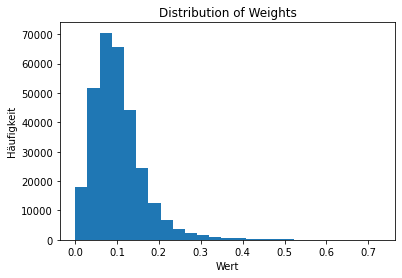

In [17]:
nn = len(graph['nodes'])
ne = len(graph['links'])
print( f"This graph has {nn} nodes and {ne} links.")

import matplotlib.pyplot as plt

weights=[]
for link in graph['links']:
    weights.append(link['weight'])
#print(sum(weights))

plt.hist(weights, bins=25)
plt.title("Distribution of Weights")
plt.xlabel("Wert")
plt.ylabel("Häufigkeit")
plt.show()

Überführt den Graphen in einen Graphen, der mithilfe von Gephi verarbeitet werden kann.

In [18]:
import networkx as nx

graphforgephi = nx.Graph()
for node in graph['nodes']:
    graphforgephi.add_node(node['id'],name = node['name'],party = node['party'],msw = node['maxTFIDF'], nReden = node['nReden']);
    #if(node['name'] == 'Angela Merkel'):
    #    print(node['tops'])

print('nodes done')
for link in graph['links']:
    if link['weight'] >= 0:#.22285057620424778:
        graphforgephi.add_edge(link['source'],link['target'],weight = link['weight'])
print('links done') 

nodes done
links done


Berechnet die vorhandenen Nachbarschaften im Graohen anhand des Louivain-Algorithmusses und fügt sie den Knoten hinzu.

In [19]:
import community as community_louvain
# compute the best partition
partition = community_louvain.best_partition(graphforgephi)

In [20]:
#Update der Knoten mit der dazugehörigen community
for i,node in enumerate(graphforgephi):
    graphforgephi.add_node(node, partition=list(partition.values())[i])

In [21]:
#speichern des Graphen, damit er in Gephi genutzt werden kann
nx.write_gexf(graphforgephi, "graphforgephi_08.gexf")
print('save done')

save done
